In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import scipy

In [2]:
class calibration ():    

    def __init__(self, image_directory_left, image_directory_right):

        self.mtx_left = 0
        self.dist_left = 0
        
        self.mtx_right = 0
        self.dist_right = 0
        
        self.h = 0
        self.w = 0
        
        self.mtx_R = 0
        self.mtx_T = 0
        self.mtx_E = 0
        self.mtx_F = 0
        
        self.img_left = 0
        self.gray_left = 0
        self.img_right = 0
        self.gray_right = 0
        
        self.image_directory_left = image_directory_left
        self.image_directory_right = image_directory_right
        self.calibrate()
    
    def calibrate (self):

        image_directory_left = self.image_directory_left
        image_directory_right = self.image_directory_right
        
        #Implement the number of vertical and horizontal corners
        nb_vertical = 9
        nb_horizontal = 6


        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
        objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d point in real world space
        imgpoints_left = [] # 2d points in image plane.
        imgpoints_right = [] # 2d points in image plane.

        images_left = glob.glob(image_directory_left)
        images_right = glob.glob(image_directory_right)
        
        image_len = len(images_left) # prolly the same number of images as images_right
        images_left.sort()
        images_right.sort()


        for i in range(image_len):
            img_left = cv2.imread(images_left[i])
            gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
            img_right = cv2.imread(images_right[i])
            gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)


            #Implement findChessboardCorners here
            ret_left, corners_left = cv2.findChessboardCorners(img_left, (nb_vertical, nb_horizontal))
            ret_right, corners_right = cv2.findChessboardCorners(img_right, (nb_vertical, nb_horizontal))


            # If found, add object points, image points (after refining them)
            if ret_left == True and ret_right == True:
                objpoints.append(objp)

                imgpoints_left.append(corners_left)
                imgpoints_right.append(corners_right)

                # Draw and display the corners
                img_left = cv2.drawChessboardCorners(img_left, (nb_vertical,nb_horizontal), corners_left,ret_left)
                cv2.imshow('img',img_left)
                cv2.waitKey(50)
                img_right = cv2.drawChessboardCorners(img_right, (nb_vertical,nb_horizontal), corners_right,ret_right)
                cv2.imshow('img',img_right)
                cv2.waitKey(50)

        cv2.destroyAllWindows()        

        
        
        h, w = img_left.shape[:2]

        term_crit_sc = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        flags_sc = cv2.CALIB_RATIONAL_MODEL
        
        ret_stereo,  mtx_left, dist_left, mtx_right, dist_right, mtx_R, mtx_T, mtx_E, mtx_F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, None, None, None, None, (w,h), flags=flags_sc, criteria=term_crit_sc)
        
        
        self.mtx_left = mtx_left
        self.dist_left = dist_left
        
        self.mtx_right = mtx_right
        self.dist_right = dist_right
        
        self.h = h
        self.w = w
        
        self.mtx_R = mtx_R
        self.mtx_T = mtx_T
        self.mtx_E = mtx_E
        self.mtx_F = mtx_F
        
        self.images_left = images_left
        self.gray_left = gray_left
        self.img_right = img_right
        self.gray_right = gray_right

        return 0

In [3]:
calibration = calibration('Stereo_calibration_images/left*.png', 'Stereo_calibration_images/right*.png')

In [4]:
mtx_R_left, mtx_R_right, mtx_P_left, mtx_P_right, mtx_Q, roi_rec_left, roi_rec_right = cv2.stereoRectify(calibration.mtx_left, calibration.dist_left, calibration.mtx_right, calibration.dist_right, (calibration.w,calibration.h), calibration.mtx_R, calibration.mtx_T, alpha=0)

map1x, map1y = cv2.initUndistortRectifyMap(calibration.mtx_left,calibration.dist_left,mtx_R_left,mtx_P_left,(calibration.w,calibration.h),cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(calibration.mtx_right,calibration.dist_right,mtx_R_right,mtx_P_right,(calibration.w,calibration.h),cv2.CV_32FC1)

In [5]:
print("mtx_left")
print(calibration.mtx_left)
print("dist_left")
print(calibration.dist_left)
print("mtx_right")
print(calibration.mtx_right)
print("dist_right")
print(calibration.dist_right)
print("w")
print(calibration.w)
print("h")
print(calibration.h)
print("mtx_R")
print(calibration.mtx_R)
print("mtx_T")
print(calibration.mtx_T)

mtx_left
[[705.12927453   0.         621.04110618]
 [  0.         705.05707114 370.57048649]
 [  0.           0.           1.        ]]
dist_left
[[-9.02183529e-01  2.97132778e-01 -1.72483447e-05  4.36746760e-04
   1.00416704e-01 -5.62250169e-01 -7.95322823e-02  2.77165195e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
mtx_right
[[702.64946401   0.         649.52136933]
 [  0.         702.9097768  373.12873795]
 [  0.           0.           1.        ]]
dist_right
[[ 8.09734618e-02 -4.83050717e-01 -1.73172985e-06  3.03151407e-04
  -4.10567846e-02  4.26097500e-01 -5.50117299e-01 -1.61900517e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
w
1280
h
720
mtx_R
[[ 0.99991383 -0.00530366 -0.01200886]
 [ 0.00527805  0.99998373 -0.00216353]
 [ 0.01202014  0.00209996  0.99992555]]
mtx_T
[[-3.57124461e+00]
 [-7.64756198e-03]
 [-1.53497214e-03]]


In [6]:
# can be used as reference for later
dir_calib = ("matrix_calib_rectify")
np.save(dir_calib + "\projection_matrix_left", mtx_P_left)
np.save(dir_calib + "\projection_matrix_right", mtx_P_right)
np.save(dir_calib + "\map_left_x", map1x)
np.save(dir_calib + "\map_left_y", map1y)
np.save(dir_calib + "\map_right_x", map2x)
np.save(dir_calib + "\map_right_y", map2y)

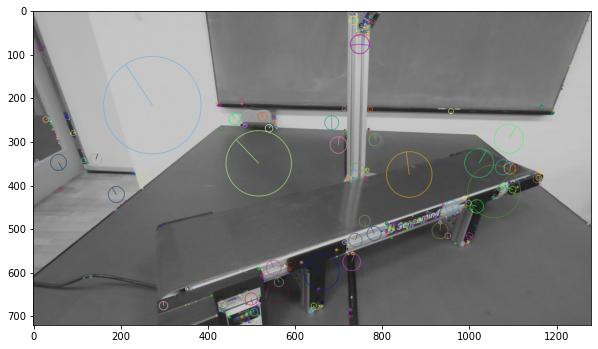

In [7]:
# map the matrix file with images
img1 = cv2.imread(r'.\Stereo_conveyor_without_occlusions\left\1585434279_805531979_Left.png', 0)
img2 = cv2.imread(r'.\Stereo_conveyor_without_occlusions\right\1585434279_805531979_right.png', 0)

# use this when running everything at once
rect_map_left_x = map1x
rect_map_left_y = map1y
rect_map_right_x = map2x
rect_map_right_y = map2y

# use this when you want to run from this block and onwards
#rect_map_left_x = np.load(r'.\matrix_calib_rectify\map_left_x.npy')
#rect_map_left_y = np.load(r'.\matrix_calib_rectify\map_left_y.npy')
#rect_map_right_x = np.load(r'.\matrix_calib_rectify\map_right_x.npy')
#rect_map_right_y = np.load(r'.\matrix_calib_rectify\map_right_y.npy')

img1 = cv2.remap(img1, rect_map_left_x, rect_map_left_y, cv2.INTER_LINEAR)
img2 = cv2.remap(img2, rect_map_right_x, rect_map_right_y, cv2.INTER_LINEAR)


sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

In [8]:
# FLANN parameters
flann = cv2.FlannBasedMatcher()
matches = flann.knnMatch(des1,des2,k=2)
matches = [m for m, n in matches]

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

In [9]:
nb_matches = 200

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    

#Implement findFundamentalMat here:
F, mask = cv2.findFundamentalMat(pts1, pts2)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [10]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

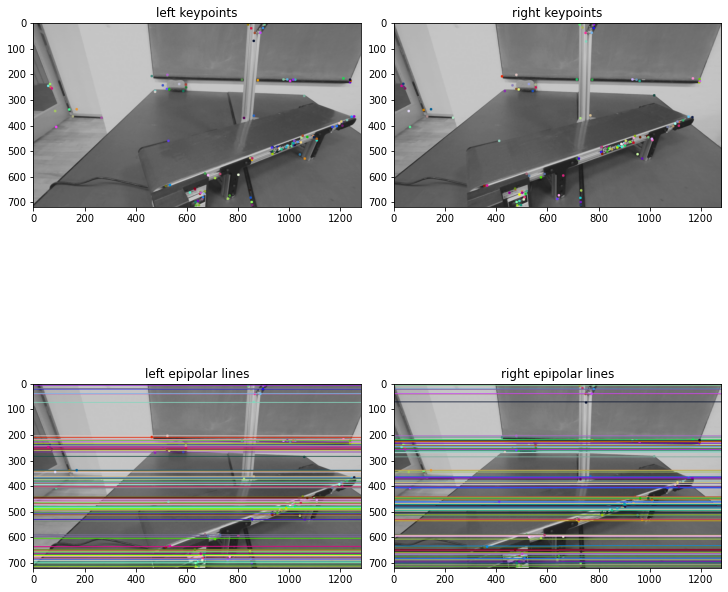

In [11]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()